In [1]:
%matplotlib inline

<html>
    <h1>Libraries used :</h1>
    <ul>
        <li>
             <img width=150px height=100px  src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Sympy_logo.svg/1200px-Sympy_logo.svg.png" class="rounded" alt="Sympy">
        </li>
        <li>        
             <img width=200px height=200px  src="https://www.fullstackpython.com/img/logos/scipy.png" class="rounded" alt="Scipy">
        </li>
        <br>
        <li>
             <img width=400px height=400px  src="https://pandas.pydata.org/_static/pandas_logo.png" class="rounded" alt="Pandas">
        </li>
        <br>
         <li>
             <img width=300px height=300px  src="https://matplotlib.org/_static/logo2.png" alt="Matplotlib">
        </li>
    </ul>

In [2]:
import numpy as np
import sympy as sm
from scipy.sparse import diags
from scipy.integrate import RK45, solve_ivp
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
import matplotlib


import time
import os
from functools import lru_cache
import math
import pandas as pd
from tqdm import tqdm_notebook


In [3]:
sm.init_printing()

plt.ioff()
plt.clf()

<html>
    <h3 align="center" style="color:#FF1C0C;"><u> Heat Equation </u> </h3> 
   <br>
</html>

\begin{equation}
\\\ u_t  + u u_x + \beta u_{xx}    = - \left(\pi^{2} \beta - \pi e^{t} \cos{\left(\pi x \right)} - 1\right) e^{t} \sin{\left(\pi x \right)}
\\ u^h = \sum_{i= 0}^{n} a_i(t)  \phi_i(x) 
\\ \int_0^1 { (w u_t +u u_x+ \beta w u_{xx})} \ dx= \int_0^1 w (- \left(\pi^{2} \beta - \pi e^{t} \cos{\left(\pi x \right)} - 1\right) e^{t} \sin{\left(\pi x \right)}) dx
\\\ \int_0^1  (w u_t + uu_x)   \ dx   - \beta \int_0^1 {w_x u_x} \ dx  + \beta \ (w(1) u_x(1) - w(0) u_x(0))= \int_0^1 w (- \left(\pi^{2} \beta - \pi e^{t} \cos{\left(\pi x \right)} - 1\right) e^{t} \sin{\left(\pi x \right)}) dx
\\  A \alpha^{'}(t) \hspace{5mm} +\alpha^T B \alpha \ -  \hspace{5mm}\beta  D \alpha(t) \hspace{10mm} +\hspace{10mm}  \beta E \alpha(t)   = f(t)
\\ w = {\phi_j}(x)
\end{equation}

\begin{equation}
\\  \alpha^{'}(t) = A^{-1}( (-\alpha^T B  +\beta ( D - E)) \alpha(t) + f(t)) \hspace{10mm} 
\end{equation}


<html>
    <h3 align="center" style="color:#FF1C0C;"><u>Boundary Conditions</u> </h3> <br>
</html>
\begin{equation}
\\  u(0, t) = 0  
\\  u(N, t) = 0
\\  u(x, 0) = sin(\pi x) 
\end{equation}

<html>
    <h3 align="center" style="color:#FF1C0C;"><u>Exact Solution</u> </h3> <br>
</html>
\begin{equation}
\\  u(x, t) = e^t sin (\pi x) 
\end{equation}

In [4]:
class Matrices:
    
    #A *alpha - beta(D *) +beta(E(1 - 0)alpha) = 0
    
    def __init__(self, N=10):
        
        self.N = N
        self.shape = (N+1, N+1)
        self.h = 1/N
        self.domain = np.linspace(0, 1, N+1) 
        self.beta = -1
        self.time_step = self.h**2
        self.runs = self.N**2
        
        self.A = (self.h) * sp.csc_matrix(diags([       [1/6 for i in range(N)],   \
                                        [1/3] + [2/3]*(N-1) + [1/3], \
                                             [1/6 for i in range(N)] ], \
                                                   [1, 0, -1]), dtype=np.float32)
        #+
        self.B = np.array([self.matB(i) for i in range(N+1)]).reshape(N+1, 1) 
        

        #-
        self.D = (1/self.h) * sp.csr_matrix(diags([      [-1 for i in range(N)],  \
                                      [1] + [2]*(N-1) + [1], \
                                        [-1 for i in range(N)]],  \
                             [1, 0, -1] ), dtype=np.float32)
                #+                
        row = np.array([0, 0, N, N])
        col = np.array([0, 1, N-1, N])
        data = np.array([1, -1, -1, 1 ])
        self.E = (1/self.h) *sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)    
      

        self.f_without_expt = np.array(
            [(-(math.pi*self.h - math.sin(math.pi*self.h))*(math.pi**2*self.beta - 1)/(math.pi**2*self.h))]+\
            [(2*(math.pi**2*self.beta*math.cos(math.pi*self.h) - math.pi**2*self.beta - math.cos(math.pi*self.h) + 1)*math.sin(math.pi*self.h*k)/(math.pi**2*self.h))\
            for k in range(1, self.N)]+[((math.pi**2*self.beta - 1)*(math.pi*self.h*math.cos(math.pi*self.N*self.h) - math.sin(math.pi*self.N*self.h) + math.sin(math.pi*self.N*self.h - math.pi*self.h))/(math.pi**2*self.h))]).reshape(self.N+1, 1)
        
        self.f_without_exp2t = np.array(
            [((1/8)*(2*math.pi*self.h - math.sin(2*math.pi*self.h))/(math.pi*self.h))]+\
            [(math.sin(math.pi*self.h)**2*math.sin(math.pi*self.h*k)*math.cos(math.pi*self.h*k)/(math.pi*self.h))\
            for k in range(1, self.N)]+[(-1/8*(2*math.pi*self.h*math.cos(2*math.pi*self.N*self.h) - math.sin(2*math.pi*self.N*self.h) + math.sin(2*math.pi*self.N*self.h - 2*math.pi*self.h))/(math.pi*self.h))]).reshape(self.N+1, 1)
              

        self.f_t = lambda t:math.exp(t)*self.f_without_expt + math.exp(2*t)* self.f_without_exp2t 
     

   
        #Set initial conditions here
        self.alpha = np.sin(np.pi* self.domain).reshape(N+1, 1)
        
        #Set solution here
        self.exact_solution = lambda t: np.sin(np.pi*self.domain).reshape(N+1, 1).dot(np.exp(t).reshape(1, -1))
        
        
    def matB(self,i):
            if i == 0 :
                row = np.array([0, 0, 1, 1])
                col = np.array([0, 1, 0, 1])
                data = np.array([-1/3, 1/3, -1/6, 1/6])
                return sp.csr_matrix((data, (row, col)), shape=self.shape,dtype=np.float32)        
            elif i == self.N:
                row = np.array([self.N-1, self.N - 1, self.N, self.N])
                col = np.array([self.N-1, self.N , self.N -1, self.N])
                data = np.array([-1/6, 1/6, -1/3, 1/3])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)   
            else:
                row = np.array([i-1]*3 + [i]*3 + [i+1]*3)
                col = np.array([col for col in range(i-1, i+1 + 1)]*3, dtype=np.float32)
                data = np.array([-1/6, 1/6, 0, -1/3, 0, 1/3, 0, -1/6, 1/6 ])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)    
            
              

In [1]:
class Methods(Matrices): 
    
    def __init__(self, num_basis = 10, method="Adam"):
        
        super().__init__(num_basis)
        eval("self."+method+"()")
        
        self.approx_half, self.approx_one = np.split(self.algo.y.flatten("F"), len(self.algo.t))  

        self.exact_half, self.exact_one =\
                            np.split(self.exact_solution(self.algo.t).flatten("F"), len(self.algo.t))

        self.error_half = math.sqrt(sum((self.approx_half - self.exact_half)**2))
        self.error_one = math.sqrt(sum((self.approx_one - self.exact_one)**2))
        
    

        
    def fun(self, t, y):

        y[0] = 0
        y[-1] = 0
        y = y.reshape(-1, 1)

        return la.inv(self.A).dot((-(y.T).dot(self.B.flatten())[0]+self.beta*(self.D - self.E)).dot(y) + self.f_t(t))
    
    def Adam(self):   
        self.algo = solve_ivp(self.fun,t_span=(0, 1),  y0=self.alpha.ravel(), \
                     t_eval= [0.5, 1], vectorized=True, first_step = self.h, method="LSODA")
        self.algo.y[[0, -1], :] = 0 # refresh boundary conditions
        
        

    def RK45(self):
        pass

NameError: name 'Matrices' is not defined

In [6]:
points = [5*j for j in range(3, 30)]

half = pd.DataFrame(data =None, columns=["Approximate", "Exact", "$ ||.||_2 \ Error $"])
one = pd.DataFrame(data =None, columns=["Approximate", "Exact", "$ ||.||_2 \ Error $"])

for i in tqdm_notebook(points):
    heateqn = Methods(i, method="Adam")
    half.loc[i] = [heateqn.approx_half, heateqn.exact_half, heateqn.error_half]
    one.loc[i] = [heateqn.approx_one, heateqn.exact_one, heateqn.error_one]    

In [3]:
half = pd.read_csv("NL HE with H B.C. t=.5.csv", index_col=0)
one = pd.read_csv("NL HE with H B.C. t=1.csv", index_col=0)

In [6]:
# half.to_csv("NL HE with H B.C. t=.5.csv")
# one.to_csv("NL HE with H B.C. t=1.csv")

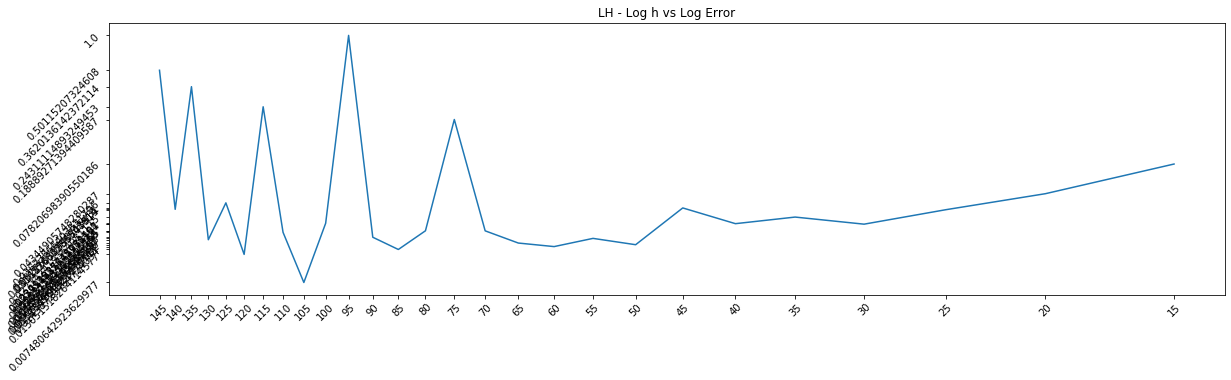

In [8]:
plt.figure(figsize=(20, 5))

plt.plot(one.iloc[:, -2], one.iloc[:, -1])

plt.title("LH - Log h vs Log Error")
_=plt.xticks(one.iloc[:, -2], labels=np.array(one.index), rotation=45)
_=plt.yticks(one.iloc[:, -1], labels=one.iloc[:, -3]/max(one.iloc[:, -3]), rotation=45)


In [4]:
one[""]

,Approximate,Exact,Errors,log h,log Error
15,[0. 0.56427427 1.10576347 1.59868609 2...,[0.00000000e+00 5.65162571e-01 1.10562483e+00 ...,0.007071,-2.708050,-4.951815
20,[0. 0.42481204 0.83999202 1.23443013 1...,[0.00000000e+00 4.25232964e-01 8.39995280e-01 ...,0.003928,-2.995732,-5.539585
25,[0. 0.34049444 0.67605202 1.000928 1...,[0.00000000e+00 3.40691051e-01 6.76009201e-01 ...,0.002858,-3.218876,-5.857617
30,[0. 0.28401995 0.5651814 0.84014227 1...,[0.00000000e+00 2.84137822e-01 5.65162571e-01 ...,0.002148,-3.401197,-6.143382
35,[0. 0.24362005 0.48543895 0.72334477 0...,[0.00000000e+00 2.43664905e-01 4.85367962e-01 ...,0.002472,-3.555348,-6.002735
40,[0. 0.21324621 0.42528572 0.63470104 0...,[0.00000000e+00 2.13273934e-01 4.25232964e-01 ...,0.002169,-3.688879,-6.133461
45,[0. 0.18960663 0.37836578 0.5652806 0...,[0.00000000e+00 1.89617755e-01 3.78311711e-01 ...,0.002962,-3.806662,-5.821808
50,[0. 0.17066367 0.34070947 0.50940992 0...,[0.00000000e+00 1.70682328e-01 3.40691051e-01 ...,0.001430,-3.912023,-6.550412
55,[0. 0.15516765 0.30987101 0.46356307 0...,[0.00000000e+00 1.55183477e-01 3.09860778e-01 ...,0.001621,-4.007333,-6.424966
60,[0. 0.14225727 0.2841569 0.42527738 0...,[0.00000000e+00 1.42263879e-01 2.84137822e-01 ...,0.001377,-4.094345,-6.587582
